In [1]:
import xarray as xr
import rioxarray
import geopandas as gpd
from landlab import RasterModelGrid, imshow_grid
from landlab.components import OverlandFlow, SinkFiller, GroundwaterDupuitPercolator
from landlab.components import CRESTHH, map_gauge_loc_to_node
from landlab.components import CREST, CoupledHydrologicProcess
import matplotlib.pyplot as plt
from landlab.io import read_geotif
from landlab.grid.mappers import map_mean_of_link_nodes_to_link
from osgeo import gdal, ogr
import fiona
import geopandas as gpd
import rasterio

In [2]:
boundaries = {'top': 'closed','bottom': 'open','right':'closed','left':'closed'}
basin= RasterModelGrid((100,160), xy_spacing=10.0, xy_axis_units='-',bc= boundaries)

In [3]:
def construct_topo(x,y):
    #z(500,800)=0
    z= abs(800-x)*0.05+(1000-y)*0.02
    return z
    

In [4]:
dem= np.array([construct_topo(_x,_y) for _y in range(0,1000,10) for _x in range(0,1600,10)]).reshape(basin.shape)
# dem[:80,:50]

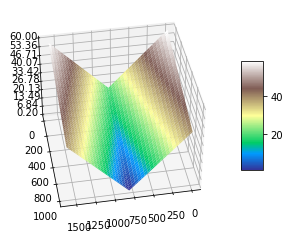

In [5]:
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import numpy as np

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# Make data.
X = np.arange(0,1600,10)
Y = np.arange(0,1000,10)
X, Y = np.meshgrid(X, Y)
R = np.sqrt(X**2 + Y**2)
Z = dem

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.terrain,
                       linewidth=0, antialiased=True)

# Customize the z axis.
# ax.set_zlim(-1.01, 1.01)
ax.zaxis.set_major_locator(LinearLocator(10))
# A StrMethodFormatter is used automatically
ax.zaxis.set_major_formatter('{x:.02f}')
ax.view_init(40, 80)
# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

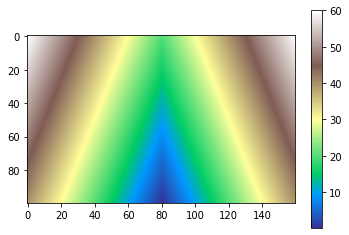

In [6]:
plt.imshow(dem, cmap='terrain')
plt.colorbar()

In [7]:
# define some model parameters
dem= dem.astype(np.float32)
_= basin.add_field('SM0__param', np.zeros_like(dem), dtype=np.float32, at='node', clobber=True)
_= basin.add_field('WM__param', np.ones_like(dem)*0.1, dtype=np.float32, at='node', clobber=True)
channel_manning= np.zeros_like(dem); channel_manning[:,79]= 0.15
riv_width= np.zeros_like(dem); riv_width[:,79]= 20
_= basin.add_field('manning_n__param', np.ones_like(dem)*0.015,
                   dtype=np.float32, at='node', clobber=True)
_= basin.add_field('B__param', np.ones_like(dem), dtype=np.float32, at='node', clobber=True)
_= basin.add_field('KE__param', np.ones_like(dem), dtype=np.float32, at='node', clobber=True)
_= basin.add_field('Ksat_groundwater__param', np.ones(basin.at_link.size,dtype=np.float32)*0.01,
                   dtype=np.float32, at='link', clobber=True)
_= basin.add_field('Ksat_unsaturated__param', np.ones_like(dem)*0.01,
                   dtype=np.float32, at='node', clobber=True)
_= basin.add_field('riv_width__param', riv_width, dtype=np.float32, at='node', clobber=True)
_= basin.add_field('riv_topo__param', dem.copy(), dtype=np.float32, at='node', clobber=True)
_= basin.add_field('riv_manning__param', channel_manning, dtype=np.float32, at='node', clobber=True)

_= basin.add_field('topographic__elevation', dem, dtype=np.float32, at='node', clobber=True)
_= basin.add_field('aquifer_base__elevation', dem-30, dtype=np.float32, at='node', clobber=True)
_= basin.add_field('aquifer__thickness', np.ones_like(dem)*10, dtype=np.float32, at='node', clobber=True)
_= basin.add_field('riv_width__param', riv_width, dtype=np.float32, at='node', clobber=True)


In [8]:
couple= CoupledHydrologicProcess(basin)
couple.proj= 'EPSG:32215'
couple.precip= np.ones_like(dem)* 100/1000./3600.
couple.evap= np.zeros_like(dem)

In [9]:
zsf= couple.zsf
zgw= couple.zgw
zrv= couple.zrv
sm= couple.SM


In [10]:
def func(y, t, spacing):

    zsf= y[:spacing[0]];sm= y[spacing[0]:spacing[1]];
    zgw= y[spacing[1]:spacing[2]];zrv= y[spacing[2]:]
    f_surf, zsf, infil, sm, qsf, qsf_link= couple._surface_flux(zsf, sm, zgw, t)
    print('surface flux:', f_surf, t)
    f_us, recharge, sm= couple._unsaturated_flux(zgw, sm, infil, t)
#     print(recharge, infil)
    print('subsurface flux:',f_us, t)
    f_gw, qgw_to_sf, qgw_to_riv, qgw= couple._ground_water_flux(zsf, zgw, zrv, recharge, t)
    print('groundwater flux:',f_gw, t)
    f_rv, qsf= couple._river_channel_flux(zrv, zsf, zgw, qsf, qsf_link, qgw_to_sf, qgw_to_riv, t)    
    print('river flux:',f_rv, t)
    dydt= np.concatenate([f_surf, f_us, f_gw, f_rv])
#     couple.free_flux()

    
    return dydt

In [11]:
from scipy.integrate import odeint

In [12]:
spacing= np.cumsum([zsf.shape, sm.shape, zgw.shape, zrv.shape])
sol = odeint(func, np.concatenate([zsf, sm, zgw, zrv]),
             [1,60],args=(spacing,), full_output=1)

surface flux: [  2.77777781e-05   2.77777781e-05   2.77777781e-05 ...,   2.77777781e-05
   2.77777781e-05   2.77777781e-05] 1.0
subsurface flux: [-0.005  0.     0.    ...,  0.     0.     0.   ] 1.0
groundwater flux: [ 0.005      -0.01179533 -0.01159541 ...,  0.          0.
  0.        ] 1.0
river flux: [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.] 1.0
surface flux: [  2.77777781e-05   2.77777718e-05   2.77777718e-05 ...,   2.77777781e-05
   2.77777781e-05   2.77777781e-05] 1.0070639126778218
subsurface flux: [ -4.96492807e-03   1.85101185e-07   1.85101185e-07 ...,   1.85101185e-07
   1.85101185e-07   1.85101185e-07] 1.0070639126778

In [13]:
zsf= sol[0][-1][:spacing[0]];sm= sol[0][-1][spacing[0]:spacing[1]];
zgw= sol[0][-1][spacing[1]:spacing[2]];zrv= sol[0][-1][spacing[2]:]

<ipython-input-14-d089b2b0f6f2>:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  cs= ax.pcolormesh(basin.x_of_node.reshape(couple.shape), basin.y_of_node.reshape(couple.shape),
<ipython-input-14-d089b2b0f6f2>:7: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  cs= ax.pcolormesh(basin.x_of_node.reshape(couple.shape), basin.y_of_node.reshape(couple.shape),
<ipython-input-14-d089b2b0f6f2>:11: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same 

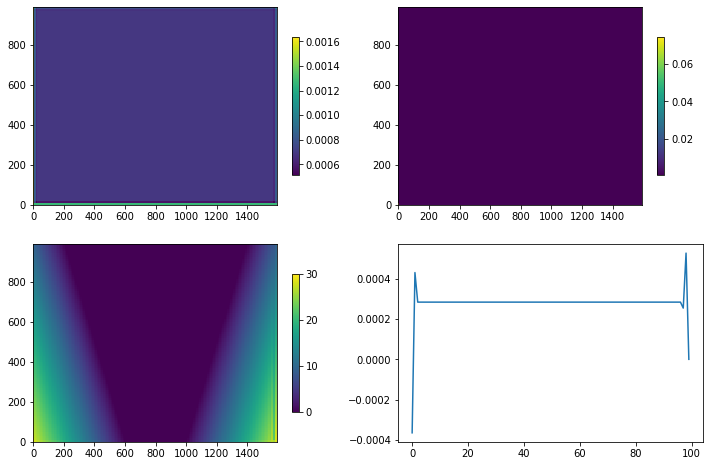

In [14]:
fig=plt.figure(figsize=(12,8))
ax= fig.add_subplot(221)
cs= ax.pcolormesh(basin.x_of_node.reshape(couple.shape), basin.y_of_node.reshape(couple.shape),
                   (zsf-couple.zsf_base).reshape(couple.shape), )
plt.colorbar(mappable=cs, shrink=0.7)
ax= fig.add_subplot(222)
cs= ax.pcolormesh(basin.x_of_node.reshape(couple.shape), basin.y_of_node.reshape(couple.shape),
                   sm.reshape(couple.shape), )
plt.colorbar(mappable=cs, shrink=0.7)
ax= fig.add_subplot(223)
cs= ax.pcolormesh(basin.x_of_node.reshape(couple.shape), basin.y_of_node.reshape(couple.shape),
                   (zgw-couple.zgw_base).reshape(couple.shape), )
plt.colorbar(mappable=cs, shrink=0.7);
ax= fig.add_subplot(224)
ax.plot(zrv-couple.zrv_btm[couple._river_cores]);

In [15]:
zrv

array([ 20.49963431,  20.30043098,  20.10028507,  19.90028433,
        19.70028547,  19.5002847 ,  19.30028394,  19.10028508,
        18.90028432,  18.70028547,  18.5002847 ,  18.30028394,
        18.10028508,  17.90028432,  17.70028547,  17.5002847 ,
        17.30028394,  17.10028508,  16.90028432,  16.70028547,
        16.5002847 ,  16.30028394,  16.10028508,  15.90028432,
        15.70028451,  15.5002847 ,  15.3002849 ,  15.10028509,
        14.90028432,  14.70028451,  14.5002847 ,  14.3002849 ,
        14.10028509,  13.90028432,  13.70028451,  13.5002847 ,
        13.3002849 ,  13.10028509,  12.90028432,  12.70028451,
        12.5002847 ,  12.3002849 ,  12.10028509,  11.90028432,
        11.70028451,  11.5002847 ,  11.3002849 ,  11.10028509,
        10.90028432,  10.70028451,  10.5002847 ,  10.3002849 ,
        10.10028509,   9.90028432,   9.70028451,   9.5002847 ,
         9.3002849 ,   9.10028509,   8.90028432,   8.70028451,
         8.5002847 ,   8.3002849 ,   8.10028509,   7.90

<ipython-input-16-b44ca20aaa7c>:1: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(basin.x_of_node.reshape(couple.shape), basin.y_of_node.reshape(couple.shape),


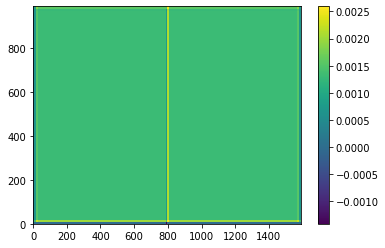

In [16]:
plt.pcolormesh(basin.x_of_node.reshape(couple.shape), basin.y_of_node.reshape(couple.shape),
                   (couple.qsf).reshape(couple.shape), )
plt.colorbar()

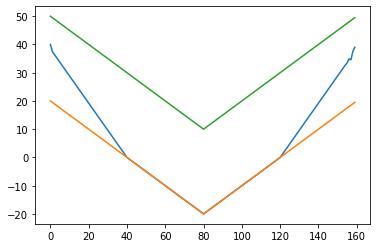

In [17]:
plt.plot(zgw.reshape(basin.shape)[50,])
plt.plot(couple.zgw_base.reshape(basin.shape)[50,])
plt.plot(zsf.reshape(basin.shape)[50,])

/Users/allen/Documents/Python/landlab/landlab/plot/imshow.py:267: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("pink"))
  cmap.set_bad(color=color_for_closed)
/Users/allen/Documents/Python/landlab/landlab/plot/imshow.py:307: MatplotlibDeprecationWarning: The 'norm' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cb = plt.colorbar(norm=norm, shrink=shrink)


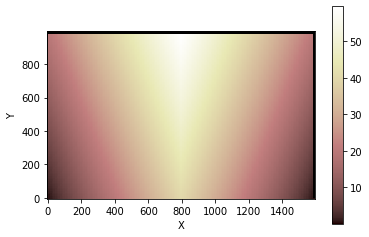

In [18]:
imshow_grid(basin, zsf-couple.zgw)

In [77]:
basin.links_at_node[couple._river_cores]* basin.link_dirs_at_node

ValueError: operands could not be broadcast together with shapes (100,4) (16000,4) 

In [74]:
basin.map_sum_of_outlinks_to_node?

Signature: basin.map_sum_of_outlinks_to_node(var_name, out=None)
Docstring:
Map the sum of links leaving a node to the node.

map_sum_of_outlinks_to_node takes an array *at the links* and finds the
outlink values for each node in the grid. it sums the outlinks and returns
values at the nodes.

.. note::

    This considers all inactive links to have a value of 0.

Parameters
----------
var_name : array or field name
    Values defined at links.
out : ndarray, optional
    Buffer to place mapped values into or `None` to create a new array.

Returns
-------
ndarray
    Mapped values at nodes.

Examples
--------
>>> import numpy as np
>>> from landlab.grid.raster_mappers import map_sum_of_outlinks_to_node
>>> from landlab import RasterModelGrid

>>> rmg = RasterModelGrid((3, 4))
>>> _ = rmg.add_field("z", np.arange(17.), at="link")
>>> map_sum_of_outlinks_to_node(rmg, 'z')
array([  3.,  5.,  7.,   6.,  17.,  19.,  21.,  13.,  14.,  15.,  16.,
         0.])

LLCATS: NINF LINF MAP
File:    

In [67]:
couple._flow_dir.flow__link_to_receiver_node()[couple._river_cores[2]]

AttributeError: 'FlowDirectorSteepest' object has no attribute 'flow__link_to_receiver_node'

In [73]:
fd.node_receiving_flow[couple._river_cores[5]]

878

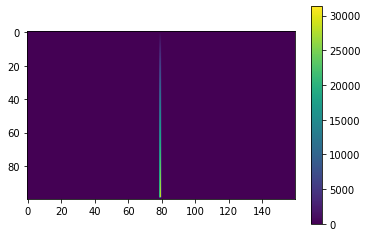

In [81]:
plt.imshow(fd.links_to_receiver.reshape(couple.shape))
plt.colorbar()

In [76]:
fd.links_to_receiver[couple._river_cores[5]]

1673

In [88]:
fd.links_to_receiver?

Type:        property
String form: <property object at 0x7f9e5daa5810>
Docstring:   ID of link downstream of each node, which carries the discharge.


In [87]:
couple._river_cores[5]

879

In [86]:
basin.nodes_at_link[1673]

array([878, 879])

In [67]:
basin.links_at_node[couple._river_cores[5]]

array([1674, 1833, 1673, 1514])

In [25]:
zsf= couple.zsf + 2.7777777e-5*60;sm= couple.SM;
zgw= couple.zgw;zrv= couple.zrv
t=60
f_surf, zsf, infil, sm, qsf, qsf_link= couple._surface_flux(zsf, sm, zgw, t)
# print(qsf_link[couple._river_cores])
print(qsf.reshape(couple.shape)[50,:])
print('surface flux:', f_surf, t)
f_us, recharge, sm= couple._unsaturated_flux(zgw, sm, infil, t)
#     print(recharge, infil)
print('subsurface flux:',f_us, t)
f_gw, qgw_to_sf, qgw_to_riv, qgw= couple._ground_water_flux(zsf, zgw, zrv, recharge, t)
# print()
print('groundwater flux:',f_gw, t)
f_rv, qsf= couple._river_channel_flux(zrv, zsf, zgw, qsf, qsf_link, qgw_to_sf, qgw_to_riv, t)    
print('river flux:',f_rv, t)
dydt= np.concatenate([f_surf, f_us, f_gw, f_rv])

[ 0.          0.00220967  0.00570345  0.00570345  0.00570345  0.00570345
  0.00570345  0.00570345  0.00570345  0.00570345  0.00570345  0.00570345
  0.00570345  0.00570345  0.00570345  0.00570345  0.00570345  0.00570345
  0.00570345  0.00570345  0.00570345  0.00570345  0.00570345  0.00570345
  0.00570345  0.00570345  0.00570345  0.00570345  0.00570345  0.00570345
  0.00570345  0.00570345  0.00570345  0.00570345  0.00570345  0.00570345
  0.00570345  0.00570345  0.00570345  0.00570345  0.00570345  0.00570345
  0.00570345  0.00570345  0.00570345  0.00570345  0.00570345  0.00570345
  0.00570345  0.00570345  0.00570345  0.00570345  0.00570345  0.00570345
  0.00570345  0.00570345  0.00570345  0.00570345  0.00570345  0.00570345
  0.00570345  0.00570345  0.00570345  0.00570345  0.00570345  0.00570345
  0.00570345  0.00570345  0.00570345  0.00570345  0.00570345  0.00570345
  0.00570345  0.00570345  0.00570345  0.00570345  0.00570345  0.00570345
  0.00570345  0.00570345  0.00919723  0.00570345  0

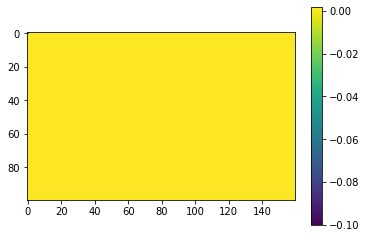

In [28]:
plt.imshow((infil - recharge- sm).reshape(basin.shape))
plt.colorbar()

In [23]:
f_surf[couple._river_cores]

array([  5.68109424e-06,  -2.92566586e-05,  -2.92567640e-05,
        -2.92566586e-05,  -2.92567640e-05,  -2.92567640e-05,
        -2.92566586e-05,  -2.92567640e-05,  -2.92566586e-05,
        -2.92567640e-05,  -2.92567640e-05,  -2.92566586e-05,
        -2.92567640e-05,  -2.92566586e-05,  -2.92567640e-05,
        -2.92567640e-05,  -2.92566586e-05,  -2.92567640e-05,
        -2.92566586e-05,  -2.92567640e-05,  -2.92567640e-05,
        -2.92566253e-05,  -2.92567640e-05,  -2.92567113e-05,
        -2.92567113e-05,  -2.92567113e-05,  -2.92567113e-05,
        -2.92567640e-05,  -2.92567113e-05,  -2.92567113e-05,
        -2.92567113e-05,  -2.92567113e-05,  -2.92567640e-05,
        -2.92567113e-05,  -2.92567113e-05,  -2.92567113e-05,
        -2.92567113e-05,  -2.92567640e-05,  -2.92567113e-05,
        -2.92567113e-05,  -2.92567113e-05,  -2.92567113e-05,
        -2.92567640e-05,  -2.92567113e-05,  -2.92567113e-05,
        -2.92567113e-05,  -2.92567113e-05,  -2.92567640e-05,
        -2.92567113e-05,